In [72]:
#librerias
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
from time import sleep

In [73]:
#Segundo punto
class Particle:
    def __init__(self, r0, v0, a0, t, Id, m=1, radius=2.):
        #Atributos únicos
        self.dt=t[1]-t[0]
        
        self.r=r0
        self.v=v0
        self.a=a0
        
        self.m=m
        self.radius=radius
        self.Id=Id
        
        self.p=self.m*self.v
        self.f = self.m*self.a

        #Historial 
        self.R=np.zeros((len(t),len(r0)))
        self.V=np.zeros_like(self.R)
        self.A=np.zeros_like(self.R)
        self.F=np.zeros_like(self.R)
        self.P=np.zeros_like(self.R)
        
        #Física (K es dureza de las esferas, VEk energía cinética, VUk y Uk energía potencial, Lz momento angular)
        self.K=20.
        self.VEk = np.zeros(len(t))
        self.VUk = np.zeros(len(t))
        self.Lz = np.zeros(len(t))
        self.Uk = np.zeros(len(t))
        
    def Evolution(self,i):
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.SetPotential(i)
        self.SetAngularMomentum(i)
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
    def CalculateForce(self,p):
        self.f=-9.81*self.m
        
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:0] = 0.
        self.a[:1] = -9.81
        
    #Setter
    def SetPosition(self,i):
        self.R[i]=self.r
        
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        
    def SetPotential(self,i):
        self.VUk[i] = -9.81*self.m*self.r[1]  
        
    def SetAngularMomentum(self,i):
        self.Lz[i] = np.cross(self.r,self.m*self.v)
        
    #Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
        
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    
    def GetPotentialEnergy(self,scale=1):
        return self.VUk[::scale] 

    def GetAngularMomentum(self,scale=1):
        return self.Lz[::scale] 
    # Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(2):
            
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                self.v[i] = -self.v[i]*0.9 #Paredes absorben, reduce velocidad
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                self.v[i] = -self.v[i]*0.9

In [74]:
def GetParticles(t):
    r0 = np.array([15.,10.])
    v0 = np.array([2.,0.])
    a0 = np.array([0.,-9.8])
    
    p0 = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)
    Particles=[p0]
    return Particles 

In [75]:
#Parámetros de tiempo y espacio
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(t)
walls = np.array([[-20., 20.],[-20., 20.]])


In [76]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
                
    return Particles

RunSimulation(t, Particles)

Running simulation: 100%|██████████| 30000/30000 [00:02<00:00, 12754.18 Steps/s]


In [77]:
scale=100
t1 = t[::scale]

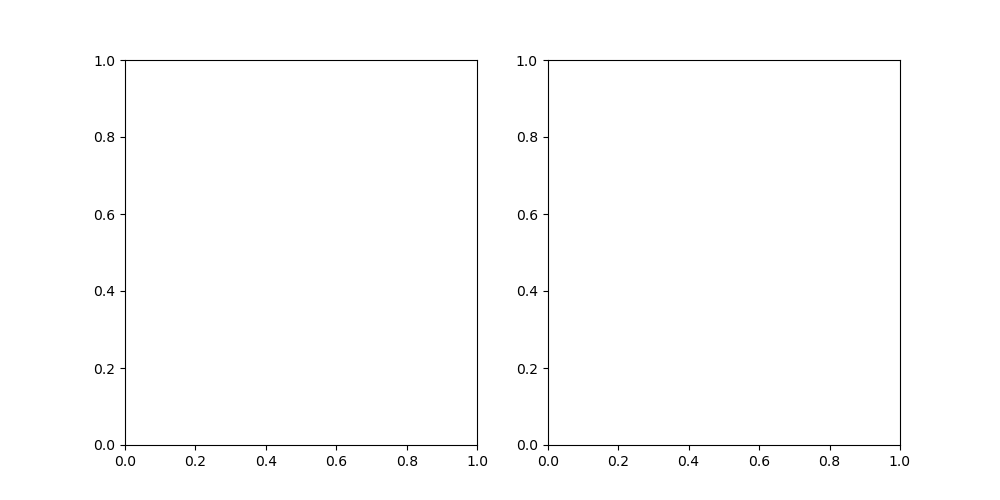

In [78]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    ax.clear()
    ax.set_xlim(walls[0][0], walls[0][1])
    ax.set_ylim(walls[1][0], walls[1][1])
    
def Update(i):
    init()
    ax.set_title(r'$ t=%.3f \ s$' %(t[i]))
    KE=0.
    UK=0.
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=True )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        UK += p.GetPotentialEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        ax2.set_title(r'Total Potential Energy: {:.3f}'.format(UK))
        ax2.scatter(t1[:i], p.GetPotentialEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

**Gráficas de energía**

In [79]:
KE = np.zeros_like(len(Particles)) # Kinetic energy
UK = np.zeros_like(len(Particles)) # Potential energy
LZ = np.zeros_like(len(Particles)) # Angular momentum
MT = Particles[0].GetMomentum(scale) # Momentum
    
for i in range(1,len(Particles)):
    MT = np.add(MT,Particles[i].GetMomentum(scale))
    KE = np.add(KE, Particles[i].GetKineticEnergy(scale))
    UK = np.add(UK, Particles[i].GetPotentialEnergy(scale))
    LZ = np.add(LZ, Particles[i].GetAngularMomentum(scale))

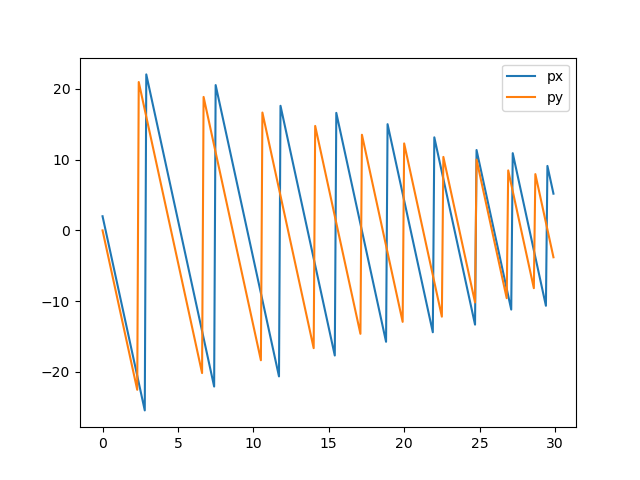

In [80]:
plt.figure()
plt.plot(t1,MT[:,0],label='px')
plt.plot(t1,MT[:,1],label='py')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (300,) and (1,)

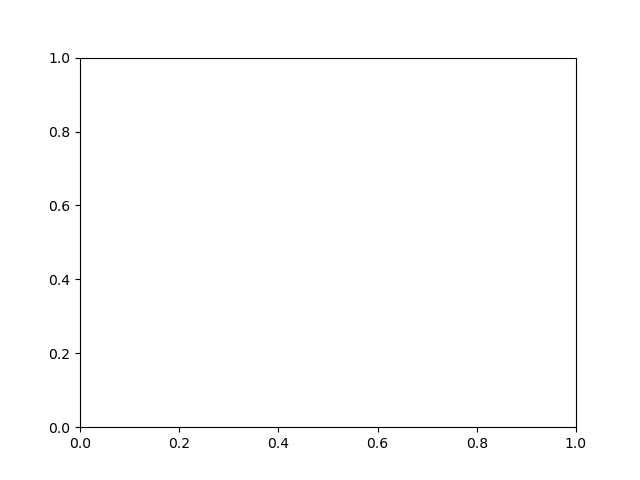

In [81]:
plt.figure()
plt.plot(t1,KE,label='Kinetic')
plt.plot(t1,UK,label='Potential')
plt.plot(t1,KE+UK,label='Mechanical')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(t1,LZ,color='k')
plt.title('Total angular momentum in z')
plt.show()